In [1]:
import numpy
from matplotlib import pyplot as plt
%matplotlib inline

## Linear regression

Data from Example 6.1 of Seborg, Edgar, Melichamp and Doyle (3rd edition)

In [2]:
import pandas

In [3]:
df = pandas.read_excel('../../assets/example_6_1.xlsx')

In [4]:
x = df['Fuel Flow Rate']
y = df['Power Generated']

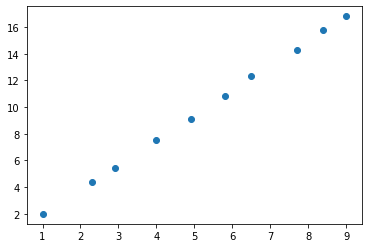

In [5]:
plt.scatter(x, y)

That resembles a straight line! Let's say the line is described by

$$y = ax + b$$

In regression, we are trying to find $a$ and $b$ given lots of values for $y$ and $x$, so we have something like

\begin{align}
y_0 &= ax_0 + b \\
y_1 &= ax_1 + b \\
y_2 &= ax_2 + b \\
\vdots &= \vdots \\
\end{align}

Which we factor as 

$$\underbrace{\begin{bmatrix}y_0\\y_1\\\vdots \end{bmatrix}}_Y = \underbrace{\begin{bmatrix}x_0 & 1 \\x_1 & 1\\\vdots & \vdots \end{bmatrix}}_X \underbrace{\begin{bmatrix}a\\b\end{bmatrix}}_\beta$$

In this case, when there are many points, $X$ is taller than it is wide and as such we know that there is no solution to the exact equations. Instead, we may try to get "close" to the solution. We can write the residuals as

$$\epsilon = Y - X\beta$$

Here, $\epsilon$ is a vector of errors, one for each data point. The (euclidian) length of this vector is given by 

$$||\epsilon|| = \sqrt{\sum_i \epsilon_i^2}$$

It is common to focus on minimising the part without the square root to make calculations simpler. This leads to the popular way of determining the error of a fit called the "sum of square errors", sometimes expressed as $||\epsilon||^2$.

This minimisation is written in mathematical notation as 

$$\min_\beta \sum_i \epsilon_i^2$$

which is read in words as as "minimise (_with respect to_ or _by changing_ $\beta$) the sum of the square error".

## Create the design matrices

The matrices $Y$ and $X$ are sometimes called the design matrices. We can build them using basic numpy functions as follows:

In [6]:
Y = numpy.asmatrix(y).T
X = numpy.bmat([numpy.c_[x], numpy.ones_like(Y)])

_Note_ `numpy.c_` produces a two dimensional array from a one dimensional one in a *c*olumn.

In the case of polynomials, $X$ is a special matrix called a [Vandermonde matrix](https://en.wikipedia.org/wiki/Vandermonde_matrix), and numpy has a function which generates them more easily.

In [7]:
X = numpy.asmatrix(numpy.vander(x, 2))

There is also a library called [patsy](https://patsy.readthedocs.io) which supplies a simplified syntax to construct these matrices:

In [8]:
Y, X = patsy.dmatrices("Q('Power Generated') ~ Q('Fuel Flow Rate')", df)

NameError: name 'patsy' is not defined

In [ ]:
Y, X = map(numpy.asmatrix, (Y, X))

### Pseudoinverse solution

First, let's apply the pseudoinverse method directly (note **you should never do this for production code**, as calculating inverses is computationally expensive)



The solution minimising the sum of the squares of the residual $||\epsilon||^2$ can be shown to be 

$$ \hat{\beta} = (X^TX)^{-1}X^T Y $$

In [ ]:
#Excel: =MMULT((MINVERSE(MMULT(TRANSPOSE(_X); _X))); MMULT(TRANSPOSE(_X); _Y))
betahat = (X.T * X).I * X.T * Y
betahat

*Note:* The code above is as close as possible to the equation above, as I have made `X` and `Y` matrices. **The numpy developers advise against using the `numpy.matrix` class**.

Matrix properties: 
* `.T`: Transpose
* `.I`: Inverse
* `.A`: Array form of matrix

Normal `numpy.array`s don't have an `.I` property and don't multiply matrix-fasion but rather element-wise. Here is how we would have to write the code if we used arrays:

In [ ]:
Y = Y.A
X = X.A

In [ ]:
numpy.linalg.inv(X.T @ X) @ X.T @ Y

The `@` operator always does matrix multiplication and expects two-dimensional arrays on both sides.

### Dedicated solvers

Calculating the inverse is not a numerically well behaved operation, so you should rather use a dedicated routine if you are solving this kind of problem:

In [ ]:
beta, residuals, rank, s = numpy.linalg.lstsq(X, Y, rcond=None)
beta

However, polynomial fits are such a common operation that there are nicer routines to do this fit. There are a whole range of functions in numpy which start with poly. Press tab to see them.

In [ ]:
numpy.poly

In [ ]:
poly = numpy.polyfit(x, y, 1)
poly

Notice that we could just pass the data directly, and the routine handled building the various matrices and the fitting itself.

It is useful to plot the regression with the data points, but we should sample on a finer grid.

In [ ]:
smoothx = numpy.linspace(min(x), max(x), 1000)

In [ ]:
def regplot(poly):
    smoothy = numpy.polyval(poly, smoothx)
    plt.scatter(x, y, label='data')
    plt.plot(smoothx, smoothy, label='linear regression')
    plt.plot(x, numpy.polyval(poly, x), label='linear regression, less points')
    plt.legend(loc='best')
regplot(poly)

There's obviously no difference between the two for a linear fit, but what about higher orders?

In [ ]:
poly9 = numpy.polyfit(x, y, 8)
regplot(poly9)

If we had just plotted the connecting lines, we would have missed the bit sticking up on the left!

## Nonlinear regression

We can apply the same principles to fit nonlinear functions as well. The `scipy.optimize.curve_fit` function can be used to fit an aribitrary function to data

In [ ]:
import scipy.optimize

Let's start by reproducing the results from the linear fit

In [ ]:
def f(x, a, b):
    """fitting function linear in coefficient"""
    return a*x + b

In [ ]:
beta, _ = scipy.optimize.curve_fit(f, x, y, [1, 0])
beta

Now let's build some data which is obviously nonlinear

In [ ]:
x = numpy.arange(1, 10)
y = 2*numpy.sin(3*x) + x + 1

In [ ]:
def f2(x, a, b, c, d):
    """ A nonlinear fitting function"""
    return a*numpy.sin(b*x)+ c*x + d

In [ ]:
def fit_and_plot(beta0):
    beta, _ = scipy.optimize.curve_fit(f2, x, y, beta0)

    plt.scatter(x, y)
    plt.plot(smoothx, f2(smoothx, *beta))
    return beta

In [ ]:
fit_and_plot([1, 1, 1, 1])

What went wrong? 

The initial values we chose were not sufficiently close to the "correct" values. This shows the first main problem with nonlinear regression: there may be multiple solutions which are returned based on the initial guess.

| Linear regression| Nonlinear regression |
|--|--|
| single correct solution  | multiple solutions possible depending on initial guess |
| requires no initial guess | requires initial guess | 
| Never returns the "wrong" local minimum solution | Sometimes claims success with "wrong" answer |
| less flexible in functional form | more flexible functional form |


Let's try a different starting point. Remember the initial data were generated with $\beta=[2, 3, 1, 1]$

In [ ]:
beta2 = fit_and_plot([2, 2.8, 1, 1])
beta2

OK, now we know we're right, right? The error of this fit is essentially zero.

In [ ]:
def fiterror(beta):
    return sum((y - f2(x, *beta))**2)

In [ ]:
fiterror(beta2)

But wait, what about this:

In [ ]:
beta3 = fit_and_plot([2, 9.2, 1, 1])
beta3

In [ ]:
fiterror(beta3)

It is clear that there are multiple solutions to this problem which are equally good! This is a property of nonlinear regression. It is often impossible to recover the "right" values of the parameters. You should therefore be careful of interpreting a good fit as evidence of correctness of your model.